# <center> AAPL - Apple Inc. </center> 
#  <center> Time Series Forecasting with ARIMA and Prophet</center> 
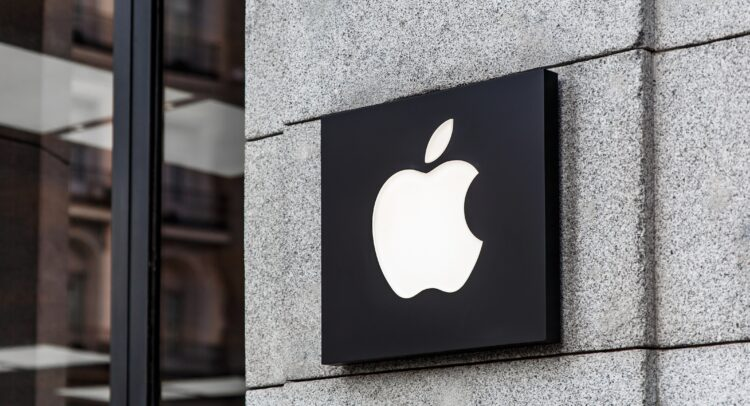

#### Context
In this project, we will study the stock AAPL (the ticker symbol for Apple Inc.). We will use the yfinance API to fetch a dataset of AAPL's historical stock prices over a period of time. This data is typically used for financial analysis, including studying trends in the stock price, predicting future prices, or analyzing the volatility of the stock.
</br></br>

#### Content
- Date: The specific date of the stock prices listed.
- Open: The price at which Apple's stock opened on that particular day.
- High: The highest price Apple’s stock reached during that day.
-Low: The lowest price Apple’s stock reached during that day.
- Close: The price at which Apple's stock closed on that day.
- Adj Close: The adjusted closing price, which reflects the stock's closing price after adjustments for any actions such as dividends or stock splits.
- Volume: The number of shares traded on that particular day.
</br></br>

We will use this dataset to perform analyses with Prophet and ARIMA models to predict future stock prices.

In [1]:
# !pip install prophet
# !pip install yfinance
# !pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Import and read time series data

In [3]:
df = yf.download("AAPL", start="2019-09-01")
df = df.resample('M').mean() # Resample the data to get monthly averages
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-30,54.431875,54.867750,53.984875,54.498750,52.735390,1.085134e+08
2019-10-31,58.732391,59.242283,58.236304,58.821630,56.918397,1.057918e+08
2019-11-30,65.423499,65.865375,65.060500,65.630126,63.659942,8.966630e+07
2019-12-31,68.847857,69.470952,68.467024,69.131428,67.095449,1.137521e+08
2020-01-31,77.792738,78.581547,77.207857,77.979048,75.682495,1.397319e+08


In [4]:
df.shape

(61, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2019-09-30 to 2024-09-30
Freq: M
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       61 non-null     float64
 1   High       61 non-null     float64
 2   Low        61 non-null     float64
 3   Close      61 non-null     float64
 4   Adj Close  61 non-null     float64
 5   Volume     61 non-null     float64
dtypes: float64(6)
memory usage: 3.3 KB


## Data visualization

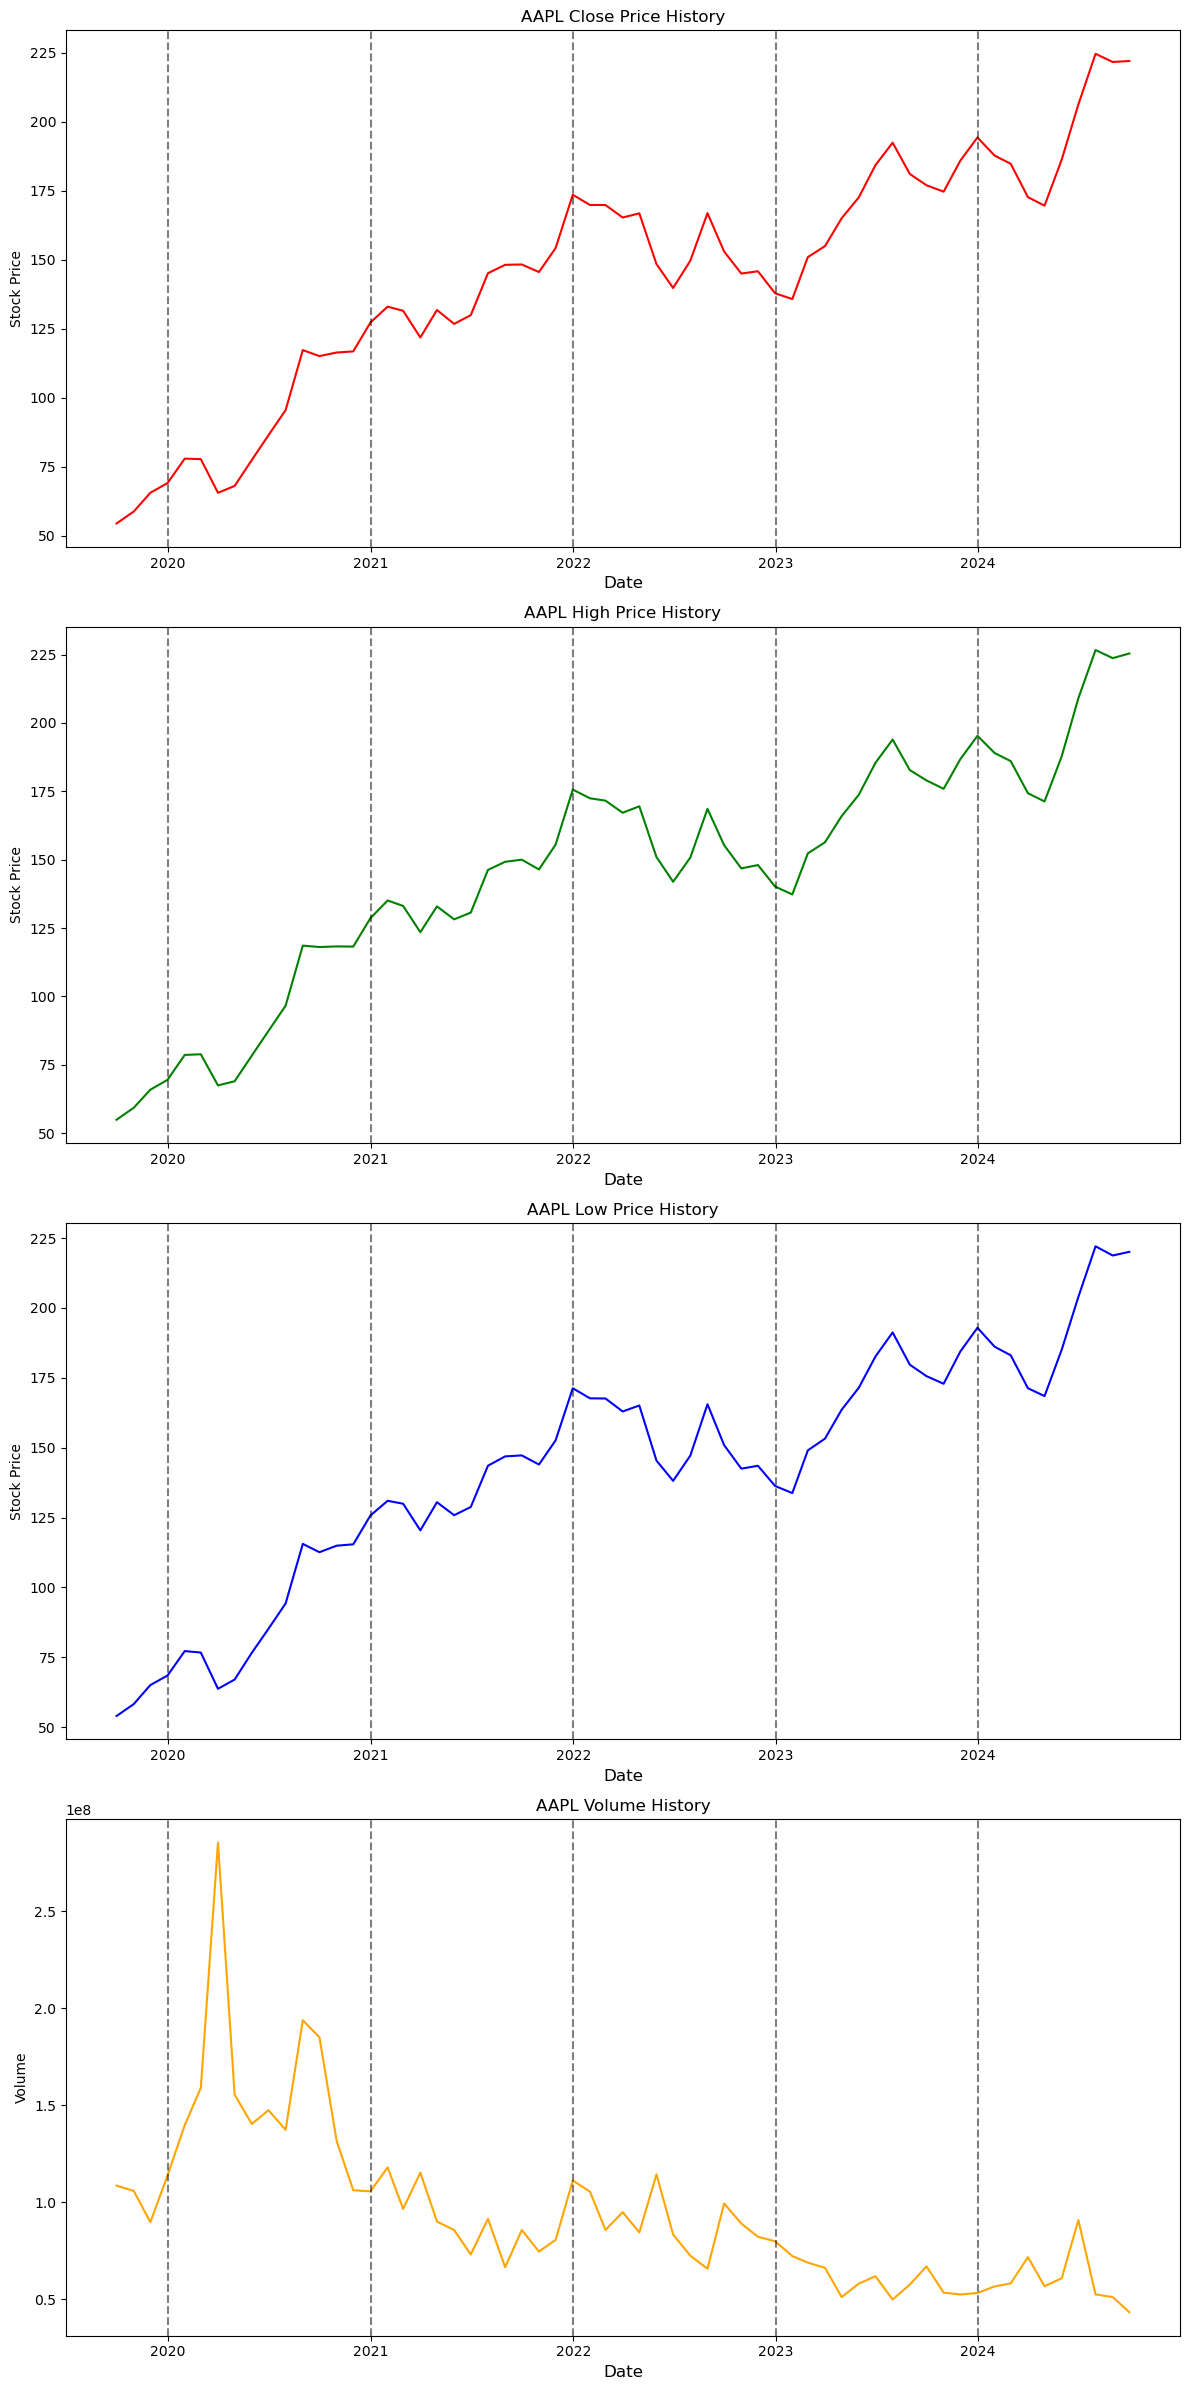

In [6]:
# Create the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))

# Close Price Plot
ax1.plot(df.index, df["Close"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AAPL Close Price History")

# High Price Plot
ax2.plot(df.index, df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("AAPL High Price History")

# Low Price Plot
ax3.plot(df.index, df["Low"], color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price")
ax3.set_title("AAPL Low Price History")

# Volume Plot
ax4.plot(df.index, df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("AAPL Volume History")

# Add vertical lines for each year in all plots
xcoords = pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS')
for xc in xcoords:
    ax1.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=xc, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Long-term Trends

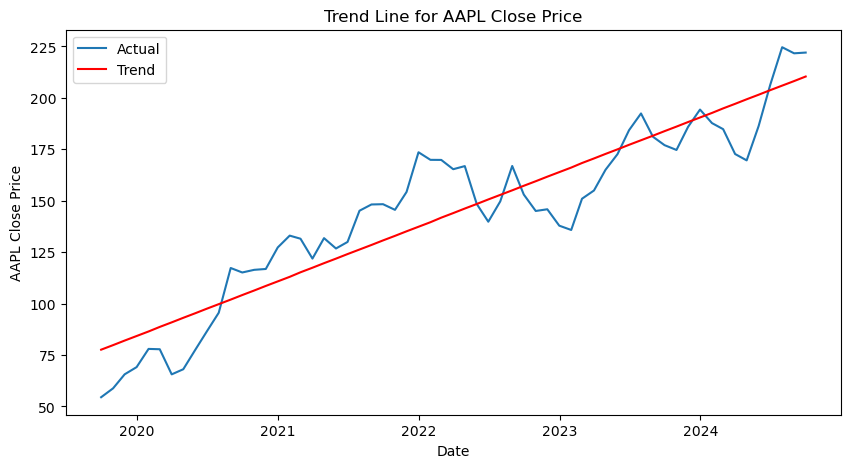

In [7]:
# Linear Regression for Trend Analysis
X = np.arange(len(df)).reshape(-1, 1)  # Time as an independent variable
y = df['Close'].values  # Close price as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the actual data and the trend line together
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, trend, label='Trend', color='red')
plt.title('Trend Line for AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()

The upward trend in AAPL's stock price reflects Apple's continuous innovation, global expansion, strong brand loyalty, and integration of AI in their products, driving sustained investor confidence and growth.

## Time Series Decomposition

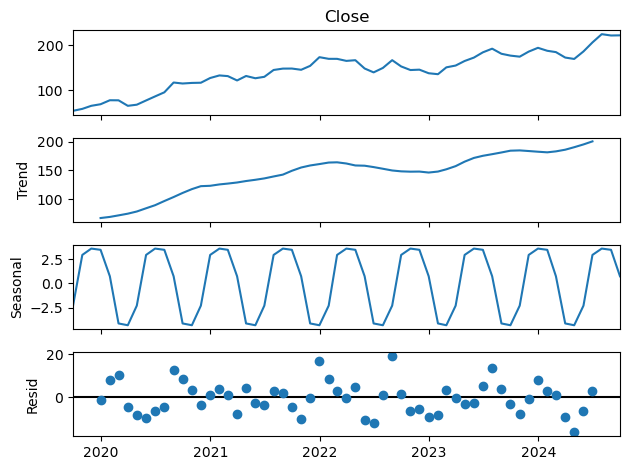

In [8]:
result = seasonal_decompose(df['Close'], model='additive', period=7)
result.plot()
plt.tight_layout()
plt.show()

## Data Preprocessing
We're likely focusing on analyzing and predicting the "Close" price of the AAPL stock, which represents the final price at which the stock was traded during a particular day. Hence, the other columns—Open, High, Low, Volume, and Adj Close—will be dropped because they are not directly relevant to this specific analysis.

In [9]:
df = df.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis= 1)
df.head()

,Close
Date,
2019-09-30,54.498750
2019-10-31,58.821630
2019-11-30,65.630126
2019-12-31,69.131428
2020-01-31,77.979048


## Train / Test Split

In [10]:
split_point = int(len(df) * 0.8)  # 80% split index
df_train = df.iloc[:split_point]  # First 80% for training
df_test = df.iloc[split_point:]   # Remaining 20% for testing

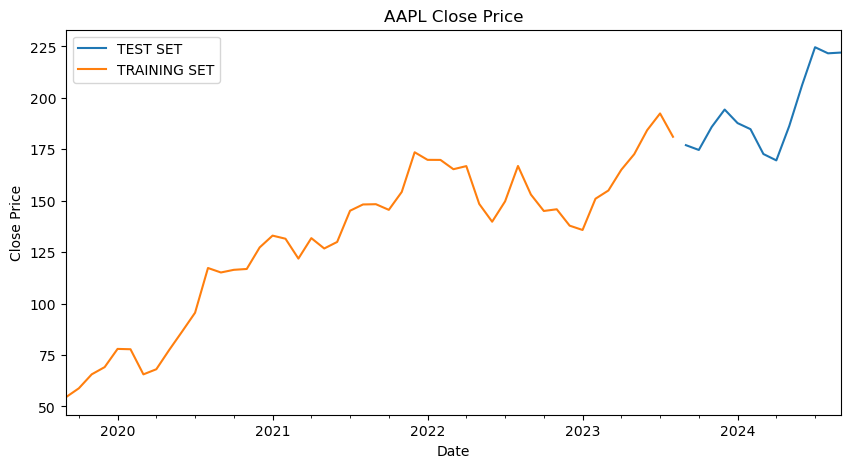

In [11]:
# Plot train and test so we can see where we have split
df_test \
    .rename(columns={'Close': 'TEST SET'}) \
    .join(df_train.rename(columns={'Close': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='AAPL Close Price', style='-', ms=1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## ARIMA

#### Define orders

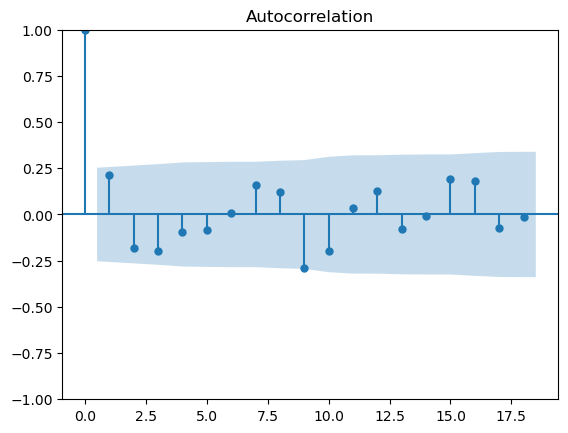

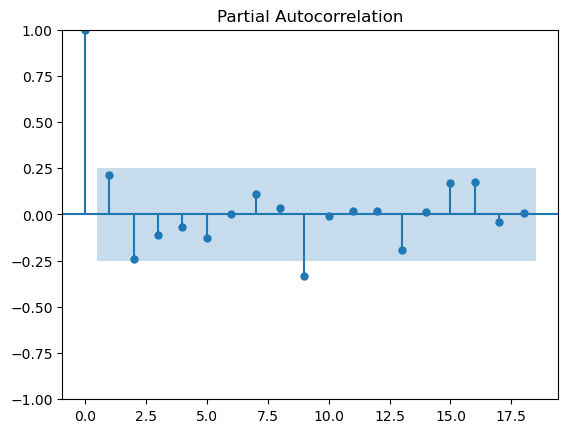

In [12]:
df_diff = df.diff().dropna()
acf_vals = plot_acf(df_diff)
pacf_vals = plot_pacf(df_diff)

- p (AR order): Since there is a significant spike at lag 1 in the PACF plot, a reasonable range for p could be 1 to 3.
- q (MA order): The ACF plot also shows a significant spike at lag 1, so a reasonable range for 
q could be 1 to 3.

Thus, you might consider trying ARIMA models with p and q values in the range of 1 to 3.

##### Initialize and fit an ARIMA model automatically
Test different combinations of ARIMA parameters (p, d, q) and automatically selects the best model based on certain criteria (like the ADF test for stationarity and information criteria such as AIC).

In [13]:
model_autoARIMA = auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=360.818, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=358.373, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=358.857, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=352.813, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=350.875, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=348.904, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=350.843, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 0.756 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   N

##### Generate predictions

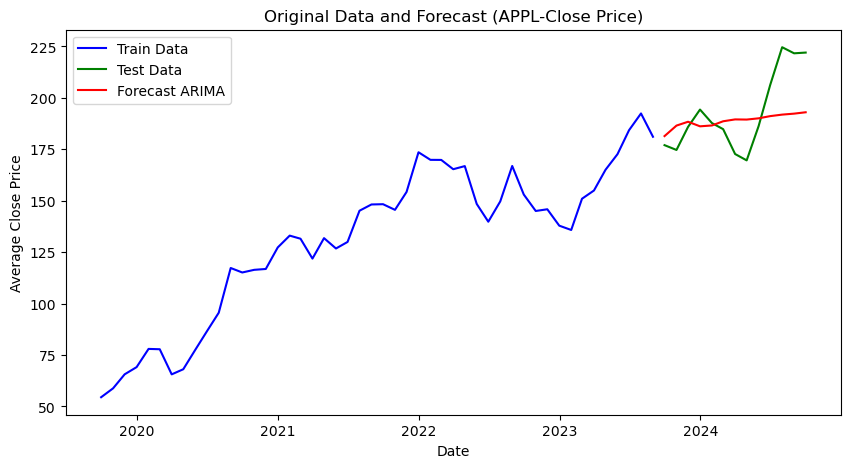

In [14]:
fct_arima = model_autoARIMA.predict(n_periods=len(df_test))

# Create a copy of the original DataFrame to store predictions
df_fct = df.copy()
df_fct['fct_arima'] = None  # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_arima'] = fct_arima

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(fct_arima.index, fct_arima, label='Forecast ARIMA', color='red')

plt.title('Original Data and Forecast (APPL-Close Price)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

##### Evaluation

In [15]:
mae_arima = mean_absolute_error(df_test, fct_arima)
mape_arima= mean_absolute_percentage_error(df_test, fct_arima) * 100
rmse_arima = np.sqrt(mean_squared_error(df_test, fct_arima))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [mae_arima, f'{mape_arima:.2f}%', rmse_arima],
})

print(performance.set_index('Metrics'))

             ARIMA
Metrics           
MAE      13.732969
MAPE         6.86%
RMSE     17.414261


## Prophet

In [16]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_train_prophet.head()

,ds,y
0,2019-09-30,54.498750
1,2019-10-31,58.821630
2,2019-11-30,65.630126
3,2019-12-31,69.131428
4,2020-01-31,77.979048


##### Fit

In [17]:
%%time
model = Prophet()
model.fit(df_train_prophet)

23:18:32 - cmdstanpy - INFO - Chain [1] start processing
23:18:32 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 93.8 ms
Wall time: 711 ms


##### Generate predictions

In [18]:
df_test.head()

,Close
Date,
2023-09-30,177.002501
2023-10-31,174.668638
2023-11-30,185.879523
2023-12-31,194.308501
2024-01-31,187.724284


In [19]:
fct_prophet = model.predict(df_test_prophet)
fct_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-30,171.262436,154.422245,183.891621,171.215501,171.309413,-2.808440,-2.808440,-2.808440,-2.808440,-2.808440,-2.808440,0.0,0.0,0.0,168.453996
1,2023-10-31,172.391898,156.356527,184.379659,172.230475,172.562688,-1.041700,-1.041700,-1.041700,-1.041700,-1.041700,-1.041700,0.0,0.0,0.0,171.350198
2,2023-11-30,173.484926,163.933327,193.086078,173.178132,173.815546,4.894846,4.894846,4.894846,4.894846,4.894846,4.894846,0.0,0.0,0.0,178.379772
3,2023-12-31,174.614389,161.205984,189.984078,174.120998,175.133672,0.755316,0.755316,0.755316,0.755316,0.755316,0.755316,0.0,0.0,0.0,175.369705
4,2024-01-31,175.743851,161.543584,189.026369,175.039908,176.485008,-0.025324,-0.025324,-0.025324,-0.025324,-0.025324,-0.025324,0.0,0.0,0.0,175.718528


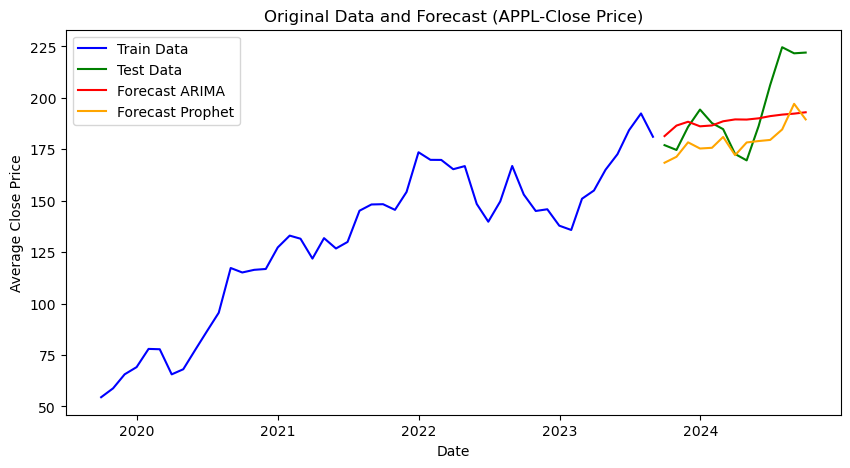

In [20]:
df_fct['fct_prophet'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_prophet'] = fct_prophet['yhat'].values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_test.index, df_fct.loc[df_test.index, 'fct_arima'], label='Forecast ARIMA', color='red')
plt.plot(df_test.index, df_fct.loc[df_test.index, 'fct_prophet'], label='Forecast Prophet', color='orange')

plt.title('Original Data and Forecast (APPL-Close Price)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

##### Cross validation

In [21]:
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.head()

,ds,y
0,2019-09-30,54.498750
1,2019-10-31,58.821630
2,2019-11-30,65.630126
3,2019-12-31,69.131428
4,2020-01-31,77.979048


In [22]:
m = Prophet().fit(df_prophet)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

23:18:33 - cmdstanpy - INFO - Chain [1] start processing
23:18:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

23:18:33 - cmdstanpy - INFO - Chain [1] start processing
23:19:03 - cmdstanpy - INFO - Chain [1] done processing
23:19:03 - cmdstanpy - INFO - Chain [1] start processing
23:19:03 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing
23:19:05 - cmdstanpy - INFO - Chain [1] start processing
23:19:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-10-31,146.544437,146.324717,146.758712,145.563809,2021-10-11
1,2021-11-30,145.099803,144.451438,145.774557,154.255716,2021-10-11
2,2021-12-31,149.191313,147.912618,150.502222,173.552727,2021-10-11
3,2022-01-31,152.248589,150.301429,154.292648,169.861500,2021-10-11
4,2022-02-28,138.725344,135.830179,141.714065,169.830001,2021-10-11


In [24]:
mae_prophet = mean_absolute_error(y_true=df_test,
                   y_pred=fct_prophet['yhat'])
mape_prophet = mean_absolute_percentage_error(y_true=df_test,
                   y_pred=fct_prophet['yhat'])*100
rmse_prophet = np.sqrt(mean_squared_error(y_true=df_test,
                   y_pred=fct_prophet['yhat']))

mae_prophet_cv = mean_absolute_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])
mape_prophet_cv = mean_absolute_percentage_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])*100
rmse_prophet_cv = np.sqrt(mean_squared_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
    'Prophet CV': [mae_prophet_cv, f'{mape_prophet_cv:.2f}%', rmse_prophet_cv],
})

print(performance.set_index('Metrics'))

           Prophet Prophet CV
Metrics                      
MAE      14.952949  28.697345
MAPE         7.29%     17.16%
RMSE     19.128476  35.702945


The cross-validated model (Prophet CV) performs worse across all metrics suggests that our model might be overfitting to the training data, leading to inflated performance on the training set and poor generalization to unseen data.

## Comparison of metrics between ARIMA and Prophet models

In [26]:
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'ARIMA': [mae_arima, f'{mape_arima:.2f}%', rmse_arima],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
})

print(performance.set_index('Metrics'))

             ARIMA    Prophet
Metrics                      
MAE      13.732969  14.952949
MAPE         6.86%      7.29%
RMSE     17.414261  19.128476


Based on the metrics provided, ARIMA appears to perform slightly better than Prophet across all three metrics (MAE, MAPE, RMSE). The differences, however, are relatively small, indicating that both models are performing similarly with ARIMA having a slight edge in this case.